In [1]:
import os
import uuid
import time
import wave
import format
import pyaudio
import librosa
import numpy as np
import soundfile as sf
import sounddevice as sd
import matplotlib.pyplot as plt

from io import BytesIO
from scipy.io import wavfile
from pydub import AudioSegment
from scipy.ndimage import maximum_filter
from scipy.signal import spectrogram, find_peaks
from matplotlib.colors import LinearSegmentedColormap
from numpy.fft import fft, ifft, fftfreq


ModuleNotFoundError: No module named 'format'

In [2]:
def my_spectrogram(audio):
    nperseg = int(format.SAMPLE_RATE * format.FFT_WINDOW_SIZE)
    return spectrogram(audio, format.SAMPLE_RATE, nperseg=nperseg)

def audio_spectrogram(filename):
    a = AudioSegment.from_file(filename).set_channels(1).set_frame_rate(format.SAMPLE_RATE)
    audio = np.frombuffer(a.raw_data, np.int16)
    return my_spectrogram(audio)

def find_peaks(Sxx):
    data_max = maximum_filter(Sxx, size=format.PEAK_BOX_SIZE, mode='constant', cval=0.0)
    # Creates a mask to identify points whose value is equal to the maximum value in its neighborhood.
    peak_goodmask = (Sxx == data_max)
    # Get the coordinates of the peaks.
    y_peaks, x_peaks = peak_goodmask.nonzero()
    # Get the values ​​of the peaks.
    peak_values = Sxx[y_peaks, x_peaks]
    # Sort the vertices in descending order of value
    i = peak_values.argsort()[::-1]
    # get co-ordinates into arr
    j = [(y_peaks[idx], x_peaks[idx]) for idx in i]

    # Calculate the number of vertices to return

    #Total number of points in the spectrum.
    total = Sxx.shape[0] * Sxx.shape[1]

    # The number of vertices to return is based on the variables
    peak_target = int((total / (format.PEAK_BOX_SIZE ** 2)) * format.POINT_EFFICIENCY)
    return j[:peak_target]

def idxs_to_tf_pairs(idxs, t, f):
    return np.array([(f[i[0]], t[i[1]]) for i in idxs])

def hash_point_pair(p1, p2):
    return hash((p1[0], p2[0], p2[1] - p1[1]))

def target_zone(anchor, points, width, height, t):
    x_min = anchor[1] + t   # Thời gian bắt đầu của vùng mục tiêu
    x_max = x_min + width   # Thời gian kết thúc của vùng mục tiêu
    y_min = anchor[0] - (height * 0.5) # Tần số bắt đầu của vùng mục tiêu,
    y_max = y_min + height # Tần số kết thúc của vùng mục tiêu
    
    # print(f"Anchor point: {anchor}")
    # print(f"Target zone x: [{x_min}, {x_max}], y: [{y_min}, {y_max}]")
    
    for point in points:
        if point[0] < y_min or point[0] > y_max:
            continue
        if point[1] < x_min or point[1] > x_max:
            continue
        yield point

"""
hash_point() Tạo ra các băm đại diện cho các điểm đặc trưng trong phổ âm thanh, 
làm cơ sở cho việc xác định bài hát dựa trên các mẫu đặc trưng của nó
"""
def hash_points(points, filename):
    hashes = []
    song_id = uuid.uuid5(uuid.NAMESPACE_OID,filename).int
    print(f"Song ID: {str(song_id)}")


    for anchor in points:
        # Với mỗi điểm cực đại, hàm sẽ xác định vùng mục tiêu xung quanh điểm đó
        for target in target_zone(anchor, points, format.TARGET_W, format.TARGET_H, format.TARGET_START):
            hashes.append((
                # Hash (Tạo ra một băm cho mỗi điểm trong vùng mục tiêu đó)
                hash_point_pair(anchor, target),
                # Time offset
                anchor[1],
                str(song_id),
            ))
    return hashes

def fingerprint_file(filename):
    f, t, Sxx = audio_spectrogram(filename)
    peaks = find_peaks(Sxx)
    peaks = idxs_to_tf_pairs(peaks, t, f)
    return hash_points(peaks, filename)

def fingerprint_audio(frames):
    f, t, Sxx = my_spectrogram(frames)
    peaks = find_peaks(Sxx)
    peaks = idxs_to_tf_pairs(peaks, t, f)
    return hash_points(peaks, "recoder")

In [3]:

def record_audio(filename=None):
    """ Record 10 seconds of audio and optionally save it to a file

    :param filename: The path to save the audio (optional).
    :returns: The audio stream with parameters defined in this module.
    """
    p = pyaudio.PyAudio()

    stream = p.open(format=format.FORMAT,
                    channels=format.CHANNELS,
                    rate=format.RATE,
                    input=True,
                    frames_per_buffer=format.CHUNK)

    print("* recording")

    frames = []
    write_frames = []

    for i in range(0, int(format.RATE / format.CHUNK * format.RECORD_SECONDS)):
        data = stream.read(format.CHUNK)
        frames.append(np.frombuffer(data, dtype=np.int16))
        if filename is not None:
            write_frames.append(data)

    print("* done recording")

    stream.stop_stream()
    stream.close()
    p.terminate()

    if filename is not None:
        wf = wave.open(filename, 'wb')
        wf.setnchannels(format.CHANNELS)
        wf.setsampwidth(p.get_sample_size(format.FORMAT))
        wf.setframerate(format.RATE)
        wf.writeframes(b''.join(frames))
        wf.close()

    return np.hstack(frames)

# INPUT AUDIO

**Convert MP3 to WAV**

In [4]:
def convert_mp3_to_wav(input_file, output_file):
    # Check if the file exists and is an MP3 file
    if os.path.exists(input_file) and input_file.lower().endswith('.mp3'):
        # Convert MP3 to WAV
        sound = AudioSegment.from_mp3(input_file)
        sound.export(output_file, format="wav")
        print(f"Converted {input_file} to WAV and saved as {output_file}")
    else:
        print("Input file is invalid. Please provide a valid MP3 file.")

mp3_folder = "D:\Khanh Ngoc\Frequency methods\PROJECT_TEST\MP3"
wav_folder = "D:\Khanh Ngoc\Frequency methods\PROJECT_TEST\WAV"

# Loop through all files in the MP3 folder
for filename in os.listdir(mp3_folder):
    if filename.endswith(".mp3"):
        mp3_file = os.path.join(mp3_folder, filename)
        wav_file = os.path.join(wav_folder, os.path.splitext(filename)[0] + ".wav")
        
        # Check if there is a corresponding WAV file in the WAV folder
        if not os.path.exists(wav_file):
            # Convert MP3 to WAV and save
            convert_mp3_to_wav(mp3_file, wav_file)
            print(f"Converted {filename} to WAV and saved as {wav_file}")
        else:
            print(f"WAV file {wav_file} already exists. Skipping...")


WAV file D:\Khanh Ngoc\Frequency methods\PROJECT_TEST\WAV\DADADA.wav already exists. Skipping...
WAV file D:\Khanh Ngoc\Frequency methods\PROJECT_TEST\WAV\DungLamTraiTimAnhDau.wav already exists. Skipping...
WAV file D:\Khanh Ngoc\Frequency methods\PROJECT_TEST\WAV\LUNGLO.wav already exists. Skipping...
WAV file D:\Khanh Ngoc\Frequency methods\PROJECT_TEST\WAV\TOTHEMOON.wav already exists. Skipping...


**Process an audio file**
<br> 
*Converts audio from multiple channels (usually stereo) into one channel (mono) by taking the first channel of audio data*

In [5]:
def convert_to_mono(input_audio, output_audio):
    # Read audio file
    audio = AudioSegment.from_file(input_audio)

    # Check the channels
    channels = audio.channels

    # If there is more than 1 channel, convert to 1 channel
    if channels > 1:
        audio = audio.set_channels(1)
    audio.export(output_audio, format="wav")

for filename in os.listdir(wav_folder):
    if filename.endswith(".wav"):
        wav_file = os.path.join(wav_folder, filename)
        mono_wav_file = os.path.join(wav_folder, "mono_" + filename)
        # Check if there is a corresponding WAV file in the WAV folder
        if not os.path.exists(wav_file):
            # Convert MP3 to WAV and save
            convert_to_mono(wav_file, mono_wav_file)
            print(f"Converted {filename} to mono and saved as {mono_wav_file}")
        else:
            print(f"Audio {wav_file} has been converted to mono channel. Skipping...")

Audio D:\Khanh Ngoc\Frequency methods\PROJECT_TEST\WAV\DADADA.wav has been converted to mono channel. Skipping...
Audio D:\Khanh Ngoc\Frequency methods\PROJECT_TEST\WAV\DungLamTraiTimAnhDau.wav has been converted to mono channel. Skipping...
Audio D:\Khanh Ngoc\Frequency methods\PROJECT_TEST\WAV\LUNGLO.wav has been converted to mono channel. Skipping...
Audio D:\Khanh Ngoc\Frequency methods\PROJECT_TEST\WAV\TOTHEMOON.wav has been converted to mono channel. Skipping...


# RECORDING

* What we have is a signal recorded in the time domain. A time domain signal represents the change in amplitude of the signal over time.
* Any signal in the time domain is equivalent to the sum of a (possibly infinite) number of simple sinusoidal signals, given that each sinusoidal component has a certain frequency, amplitude, and phase. paragraph. The sequence of sinusoids that together form the original time domain signal is called its Fourier series.
* It is possible to represent any time domain signal by simply giving the set of frequencies, amplitudes, and phases corresponding to each sinusoid that makes up the signal. This representation of the signal is called the frequency domain. In some ways, the frequency domain acts as a kind of fingerprint or signature for a time domain signal, providing a static representation of a dynamic signal.

In [6]:
import pyaudio
import wave

def get_format():
    sample_rate = 44100
    sample_size_in_bits = pyaudio.paInt16
    channels = 1
    chunk = 1024
    return sample_rate, sample_size_in_bits, channels, chunk

sample_rate, sample_size_in_bits, channels, chunk = get_format()
record_seconds = 10
output_filename = "recorded.wav"

# Tạo một đối tượng PyAudio
p = pyaudio.PyAudio()

Shazam = 'D:\Khanh Ngoc\Frequency methods\PROJECT_TEST\SHAZAM'
for f in os.listdir(Shazam):
    for filename in os.listdir(wav_folder):
        if filename.endswith(".wav"):
            if not os.path.exists(f):
                # Mở luồng để ghi âm
                stream = p.open(format=sample_size_in_bits,
                                channels=channels,
                                rate=sample_rate,
                                input=True,
                                frames_per_buffer=chunk)

                print("Recording...")

                frames = []

                # Ghi âm trong 10 giây
                for i in range(0, int(sample_rate / chunk * record_seconds)):
                    data = stream.read(chunk)
                    frames.append(data)

                print("Recording ends")

                # Dừng luồng ghi âm và đóng nó
                stream.stop_stream()
                stream.close()
                p.terminate()

                # Lưu dữ liệu vào tệp WAV
                wf = wave.open(output_filename, 'wb')
                wf.setnchannels(channels)
                wf.setsampwidth(p.get_sample_size(sample_size_in_bits))
                wf.setframerate(sample_rate)
                wf.writeframes(b''.join(frames))
                wf.close()

                print(f"File is saved '{output_filename}'")
            else: 
                print(f"Audio already exist")

Recording...
Recording ends
File is saved 'recorded.wav'


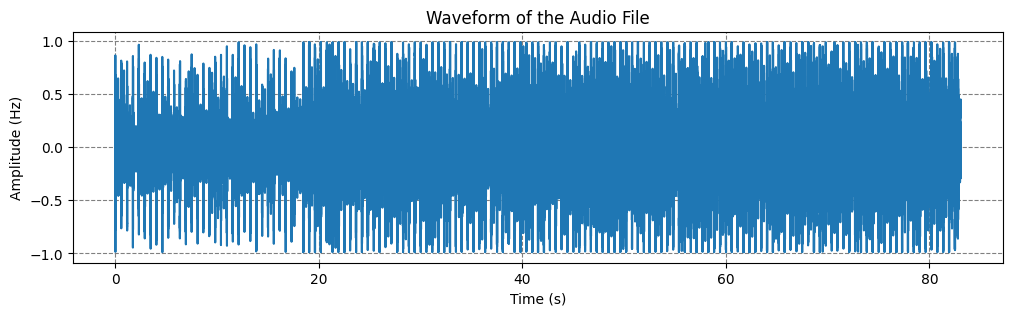

In [8]:
filename = 'D:\Khanh Ngoc\Frequency methods\PROJECT_TEST\MP3\mexican-audiocoffee.wav'
y, f = librosa.load(filename, sr=None)

time = np.linspace(0, len(y) / f, num=len(y))
plt.figure(figsize=(12, 3))
plt.plot(time, y)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (Hz)')
plt.title('Waveform of the Audio File')
plt.grid(color='gray', linestyle='--')
plt.show()


Text(0.5, 1.0, 'Fourier Transfom of audio')

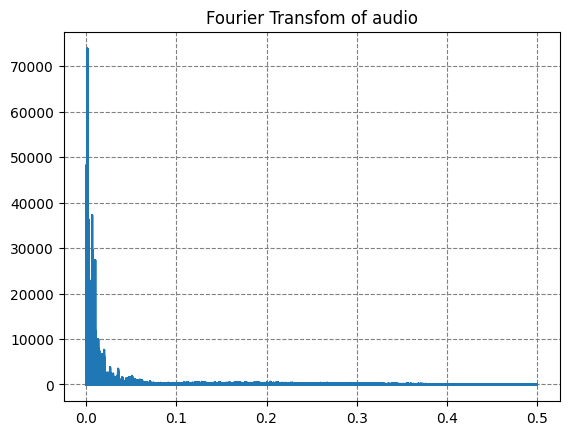

In [9]:
y_fft = np.fft.fft(y)
freq = np.fft.fftfreq(np.size(y_fft))

plt.plot(abs(freq), abs(y_fft))
plt.grid(color='gray', linestyle='--')
plt.title("Fourier Transfom of audio")


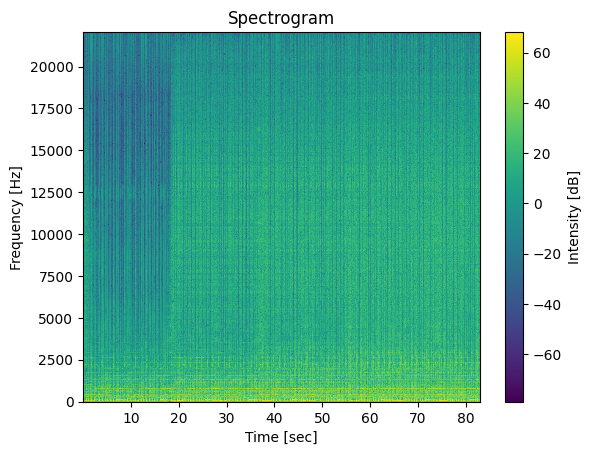

In [14]:
f, t, Sxx =  audio_spectrogram(filename)

# Vẽ phổ
plt.pcolormesh(t, f, 10 * np.log10(Sxx))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram')
plt.colorbar(label='Intensity [dB]')
plt.show()


Функция find_peaks используется для поиска пиков в спектре аудиосигнала. Он использует размер области вокруг каждого пика для определения и расчета количества возвращаемых пиков на основе количества пиков, которые теоретически могут вписаться в спектр, и эффективности точки.

In [ ]:
peaks = find_peaks(Sxx)

plt.figure(figsize=(12,4))
for peak in peaks:
    #'-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
    plt.plot(t[peak[1]], f[peak[0]], 'gx')
plt.grid(linestyle='--')
plt.title("«Kарта созвездия» вершин песни")
plt.xlabel("Time(s)")
plt.ylabel("Frequenc(Hz)")
plt.show()

In [ ]:
# Tìm các đỉnh cao nhất
peaks_indices, _ = find_peaks(Sxx)

# Lọc chỉ giữ lại các đỉnh cao nhất cho mỗi khung thời gian
filtered_peaks = []
for i in range(len(t)):
    peak_values = Sxx[:, i][peaks_indices[:, i]]
    max_peak_index = peaks_indices[:, i][np.argmax(peak_values)]
    filtered_peaks.append((f[max_peak_index], t[i]))

filtered_peaks = np.array(filtered_peaks)

In [ ]:
tf_pairs = idxs_to_tf_pairs(peaks, t, f)

In [ ]:
song_id = fingerprint_file(filename)
print(song_id)

Song ID: 213574011625526378083409185242351594886
[(-1287822532933953590, 25.476643990929706, '213574011625526378083409185242351594886'), (-7343764995737127177, 25.476643990929706, '213574011625526378083409185242351594886'), (1406910553367856705, 25.476643990929706, '213574011625526378083409185242351594886'), (167760565666800374, 53.12843537414966, '213574011625526378083409185242351594886'), (7055907138734528918, 53.12843537414966, '213574011625526378083409185242351594886'), (-4260010813740005884, 53.12843537414966, '213574011625526378083409185242351594886'), (1553586637014386088, 53.12843537414966, '213574011625526378083409185242351594886'), (2722085992922936691, 53.12843537414966, '213574011625526378083409185242351594886'), (2223882668267917989, 82.00530612244899, '213574011625526378083409185242351594886'), (-1597292976055924382, 82.00530612244899, '213574011625526378083409185242351594886'), (-7307844392096916064, 82.00530612244899, '213574011625526378083409185242351594886'), (9034527

# PROCESSING AN AUDIO FILE

In [ ]:
# Ghi âm và lưu vào tệp 'recorded.wav'
audio_filename = 'recorded.wav'
recorded_audio = record_audio(audio_filename)

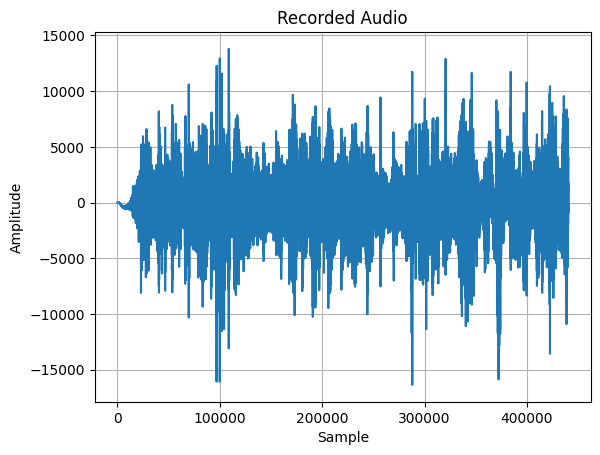

In [ ]:
# Đọc tệp âm thanh đã ghi và phát lại
rate, audio_data = wavfile.read(audio_filename)
plt.plot(audio_data)
plt.title("Recorded Audio")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid('--')
plt.show()

**Filter audio**

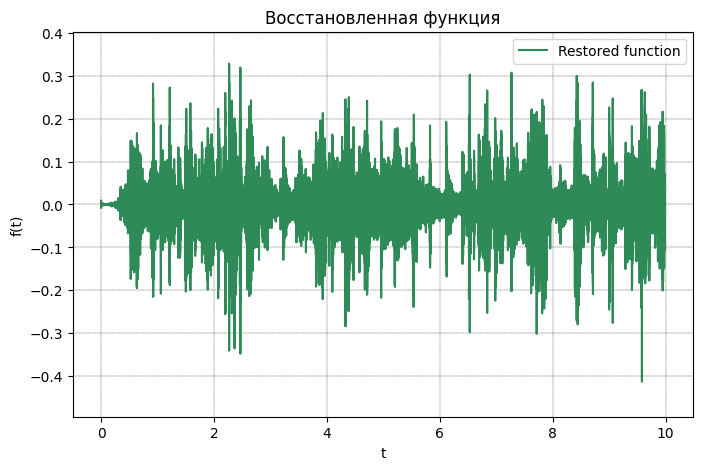

In [ ]:
def plot_func(X, func, color, caption, title, legend=['Restored function']):
    ymin = min(func) 
    ymax = max(func) 
    ymax = ymax + 0.1 * (ymax - ymin)
    ymin = ymin - 0.1 * (ymax - ymin)
    plt.figure(figsize=(8, 5)) 
    plt.ylim(ymin, ymax)
    plt.plot(X, func.real, color=f'{color}')
    plt.xlabel('t')
    plt.ylabel('f(t)')
    plt.legend(legend, loc='upper right')
    # add caption
    plt.title(caption)
    plt.grid(color='black', linestyle='--', linewidth=0.25)
    if title != '':
        plt.savefig(title + '.png')
    

def plot_image(X, func, caption, title):
    ymin = min(func.real.min(), func.imag.min())
    ymax = max(func.real.max(), func.imag.max())
    ymax = ymax + 0.1 * (ymax - ymin)
    ymin = ymin - 0.1 * (ymax - ymin)
    plt.figure(figsize=(8, 5)) 
    plt.ylim(ymin, ymax)
    plt.plot(X, func.real, color='green')
    plt.plot(X, func.imag, color='red')
    plt.xlabel('\u03C9')
    plt.ylabel('f(\u03C9)')
    plt.legend(['Real', 'Imag'], loc='upper right')
    # add caption
    plt.title(caption)
    plt.grid(color='black', linestyle='--', linewidth=0.25)
    if title != '':
        plt.savefig(title + '.png')


def cmp_func(X, func1, func2, caption, title, legend=['Source function', 'Restored function']):
    ymin = min(min(func1), min(func2))
    ymax = max(max(func1), max(func2)) 

    ymax = ymax + 0.1 * (ymax - ymin)
    ymin = ymin - 0.1 * (ymax - ymin)

    plt.figure(figsize=(8, 5)) 

    plt.ylim(ymin, ymax)
    plt.plot(X, func1.real, color='black')
    plt.plot(X, func2.real, color='tomato')
    plt.xlabel('t')
    plt.ylabel('f(t)')
    plt.legend(legend, loc='upper right')
    # add caption
    plt.title(caption)
    plt.grid(color='black', linestyle='--', linewidth=0.25)
    if title != '':
        plt.savefig(title + '.png')


def dot_product(X, f, g):
    dx = X[1] - X[0]
    return np.dot(f, g) * dx


get_fourier_image = lambda X, V, func: np.array([1 / (np.sqrt(2 * np.pi)) * dot_product(X, func, (lambda t: np.e ** (-1j * 2 * np.pi * image_clip * t))(X)) for image_clip in V])
get_fourier_function = lambda X, V, image: np.array([1 / (np.sqrt(2 * np.pi)) * dot_product(V, image, (lambda t: np.e ** (1j * 2 * np.pi * x * t))(V)) for x in X])


clip_delta_image_values = lambda pivot, delta: lambda X, func: np.array([0 if (pivot - delta <= X[i] <= pivot + delta  or pivot - delta <= -X[i] <= pivot + delta)else func[i] for i in range(len(func))])


def audio_fm(filename, n):
    if not os.path.exists(f'./audio/{n}'):
        os.makedirs(f'./audio/{n}')
    # read audio file
    samples, sr = librosa.load(filename)
    samples = librosa.resample(samples, orig_sr=sr, target_sr=10000)
    sr = 10000 

    # plot audio file
    # plot_func(np.linspace(0, len(samples) / sr, len(samples)), samples, 'black', f'Аудио файлы', f'./audio/{n}/Source waveform')

    # get image 
    image = fft(samples)
    V = fftfreq(len(samples), 1 / sr)
    # plot_image(V, image, 'Фурье-образ', f'./audio/{n}/Fourier image')

    clipped_image = clip_delta_image_values(pivot=200, delta=200)(V, image)

    # plot_image(V, clipped_image, 'Обрезанный образ', f'./audio/{n}/Clipped image')

    restored = ifft(clipped_image).real


    # plot restored audio file
    plot_func(np.linspace(0, len(samples) / sr, len(samples)), restored, 'seagreen', 'Восстановленная функция', f'./audio/{n}/Restored audio file')

    sf.write('Filterd.wav', restored, sr, subtype='PCM_24')

audio_fm(audio_filename, 2)
# audio_fm(2)


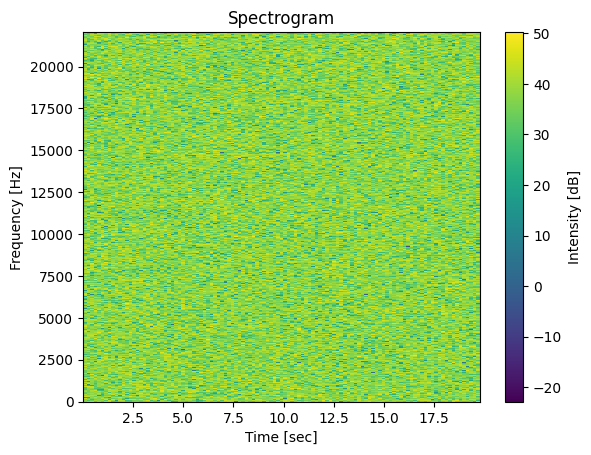

In [ ]:
filtered_audio = 'D:\Khanh Ngoc\Frequency methods\PROJECT_TEST\SHAZAM\Filterd.wav'
f, t, Sxx =  audio_spectrogram(filtered_audio)
    # Vẽ phổ
plt.pcolormesh(t, f, 10 * np.log10(Sxx))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram')
plt.colorbar(label='Intensity [dB]')
plt.show()

In [ ]:
# Tìm các đỉnh trong phổ
peaks = find_peaks(spectrogram_data)

# Vẽ phổ và các đỉnh
plt.pcolormesh(t, f, 10 * np.log10(Sxx))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram with Peaks')
plt.colorbar(label='Intensity [dB]')
for peak in peaks:
    plt.plot(t[peak[1]], f[peak[0]], 'r.')
plt.show()




* BĂM ĐIỂM

In [ ]:
# Điểm thứ nhất: (tần số, thời gian)
p1 = (1500, 0.1)  # Ví dụ: tần số 1500 Hz, thời gian 0.1 giây

# Điểm thứ hai: (tần số, thời gian)
p2 = (1600, 0.3)  # Ví dụ: tần số 1600 Hz, thời gian 0.3 giây

# Sử dụng hàm để tạo giá trị băm từ hai điểm
hash_value = hash_point_pair(p1, p2)

print("Giá trị băm từ hai điểm:", hash_value)


In [ ]:
# Các điểm tần số/thời gian
points = [(500, 1), (510, 2), (520, 3), (530, 4), (540, 5), (550, 6)]

# Điểm gốc
anchor = (520, 3)

# Vùng mục tiêu
width = 4
height = 100
t = 1

# Tạo generator
gen = target_zone(anchor, points, width, height, t)

# Tạo danh sách để lưu các điểm trong vùng mục tiêu
points_in_target_zone = []
for point in gen:
    points_in_target_zone.append(point)

print("Points in target zone:", points_in_target_zone)


In [ ]:
# Điểm đặc trưng, ví dụ: [(f1, t1), (f2, t2), ...]
points = [(500, 1), (510, 2), (520, 3), (530, 4), (540, 5), (550, 6)]

# Gọi hàm hash_points để tạo các băm cho các điểm đặc trưng
hashes = hash_points(points, filename)

# In các băm kết quả
for h in hashes:
    print("Hash:", h[0])
    print("Time offset:", h[1])
    print("Song ID:", h[2])
    print()
